In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Distribution uniforme

In [24]:
from numpy.random import rand
N = 100
M = 10000
data = rand(M, N)

In [25]:
# moyenne
estimateur_1 = data.mean(axis=1)

# min/max
estimateur_2 = (data.min(axis=1) + data.max(axis=1))/2

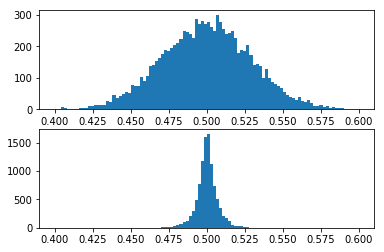

In [31]:
plt.subplot(2, 1, 1)
plt.hist(estimateur_1, bins=100, range=(0.4, 0.6));
plt.subplot(2, 1, 2)
plt.hist(estimateur_2, bins=100, range=(0.4, 0.6));

In [27]:
print(estimateur_1.std())
print(estimateur_2.std())

0.0291274319327
0.00694412277073


### Loi de Poisson

In [50]:
from numpy.random import binomial, poisson
import scipy.stats
N = 10000

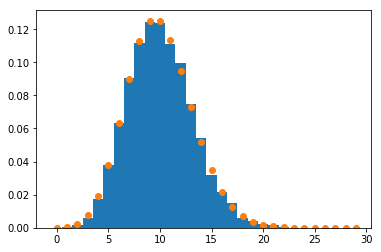

In [61]:
# Loi de poisson
lamb = 10
data_0 = poisson(lamb, size=N)
plt.hist(data_0, bins=np.arange(30)-.5, normed=True);
plt.plot(scipy.stats.poisson.pmf(np.arange(30), mu=10), 'o')

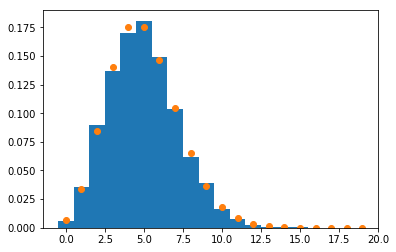

In [66]:
# Loi de poisson
lamb = 10
data_0 = poisson(lamb, size=N)
data_1 = binomial(data_0, p=1/2)
plt.hist(data_1, bins=np.arange(20)-.5, normed=True);
plt.plot(scipy.stats.poisson.pmf(np.arange(20), mu=10/2), 'o')

In [67]:
print(data_1.mean())
print(data_1.std()**2)

4.9749
4.92106999


4.8354
2.59290684


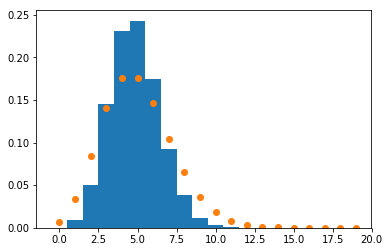

In [74]:
data_0
data_2 = data_0//2
data_2[(data_0%2)==1] += np.random.binomial(2, p=.1, size=N)[(data_0%2)==1]
plt.hist(data_2, bins=np.arange(20)-.5, normed=True);
plt.plot(scipy.stats.poisson.pmf(np.arange(20), mu=10/2), 'o')
print(data_2.mean())
print(data_2.std()**2)

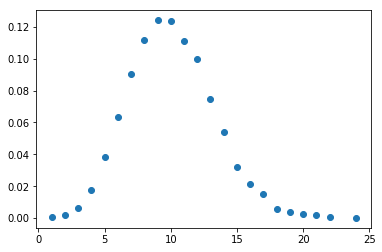

In [65]:
val, freq = np.unique(data_0, return_counts=True)
plt.plot(val, freq/N, 'o')

In [71]:
np.random.binomial(2, p=.1, size=10)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0])

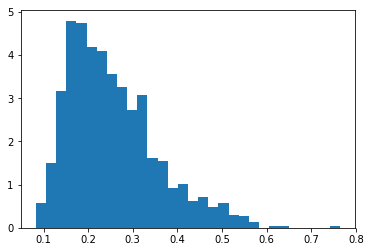

In [64]:
N = 1000

z0_moyen = 30e-2 #m
w0 = 1e-6 #m

sigma_v = 1 #m/s

g = 10 #N.kg-1 ou m/s**2

def calcul_ti(z0, vz0):
    return vz0/g + 1/g * np.sqrt(vz0**2 + 2*g*z0)

vz0 = np.random.normal(0, sigma_v, N)
z0 = np.random.normal(z0_moyen, w0, N)

ti = calcul_ti(z0, vz0)
plt.hist(ti, bins=30, normed=True);

In [26]:
M = 100

def calcul_g1(ti, z0_moyen=z0_moyen):
    return 2*z0_moyen/np.mean(ti**2)

def calcul_g2(ti, z0_moyen=z0_moyen):
    return 2*z0_moyen/np.mean(ti)**2

def generate_ti(z0_moyen=z0_moyen, w0=w0, sigma_v=sigma_v, N=N):
    vz0 = np.random.normal(0, sigma_v, N)
    z0 = np.random.normal(z0_moyen, w0, N)
    ti = calcul_ti(z0, vz0)
    return ti

def test_estimateur(estimateur, M=M, **kwd):
    
    g_est = []
    for k in range(M):
        ti = generate_ti(**kwd)
        g_est.append(estimateur(ti))
    g_est = np.array(g_est)
    return g_est.mean(), g_est.std()

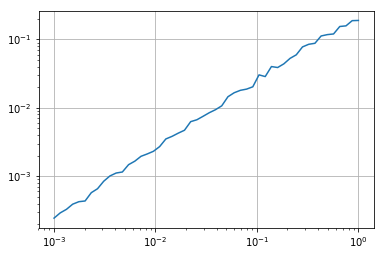

In [25]:
l_sigma_v = np.logspace(-3, 0)
l_g = [test_estimateur(calcul_g1, sigma_v=sigma_v) for sigma_v in l_sigma_v]

l_g = np.array(l_g)

plt.loglog(l_sigma_v, l_g[:, 1])
plt.grid()

In [27]:
test_estimateur(calcul_g2)

(8.6696715418711108, 0.20534269390748558)

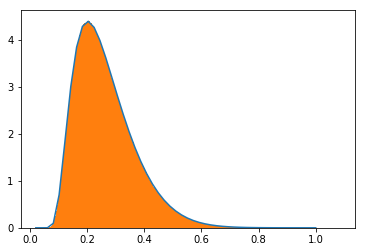

In [39]:
def f_inverse(t, g=g, z0_moyen=z0_moyen):
    return 1/t * (1/2 * g * t**2 - z0_moyen)

def df_inverse(t, g=g, z0_moyen=z0_moyen):
    return 1/2 * g + z0_moyen/t**2

def P_t(t, g=g, z0_moyen=z0_moyen, sigma_v = sigma_v):
    v = f_inverse(t, g, z0_moyen)
    p = 1/(np.sqrt(2*np.pi)*sigma_v) * np.exp(-v**2/2/sigma_v**2)
    return p*df_inverse(t, g, z0_moyen)

l_t = np.linspace(0, 1)[1:]
plt.plot(l_t, P_t(l_t))
plt.hist(ti, bins=300, normed=True);

In [55]:
N=1000
ti = generate_ti(z0_moyen=z0_moyen, w0=w0, sigma_v=sigma_v, N=N)

def log_likelyhood(p, ti=ti, z0_moyen=z0_moyen):
    g, sigma_v = p
    return -np.sum(np.log(P_t(ti, g=g, z0_moyen=z0_moyen, sigma_v=sigma_v)))

log_likelyhood((8, 0.1))

39027.221432918974

In [56]:
from scipy.optimize import fmin

N=1000
ti = generate_ti(z0_moyen=z0_moyen, w0=w0, sigma_v=sigma_v, N=N)
fmin(log_likelyhood, x0=(10, 1), args=(ti, z0_moyen))

Optimization terminated successfully.
         Current function value: -955.568937
         Iterations: 32
         Function evaluations: 62


array([ 10.32457759,   1.03153147])

In [60]:
def calcul_g_LH(ti, z0_moyen=z0_moyen):
    return fmin(log_likelyhood, x0=(10, 1), args=(ti, z0_moyen), disp=0)[0]

calcul_g_LH(ti)

10.324577591183111

In [62]:
test_estimateur(calcul_g_LH, M=2000)

(10.006589782267438, 0.23855999681383291)